In [ ]:
import pandas as pd
import xlrd

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")


Mounted at /content/drive/


In [ ]:
path = '/content/drive/Shareddrives/datathon/raw_data/Viva-Tec-data.xlsx'

# read all sheets
sheet_to_df_map = pd.read_excel(path, sheet_name=None)

In [ ]:
# Create a copy of the original sheet_to_df_map
df_map = sheet_to_df_map

In [ ]:
# Rename columns
cols = ['Date', 'NPS', 'Comment']
df_map['Booking flow'].columns = cols
df_map['Checkin'].columns = cols
df_map['Manage my booking'].columns = cols

In [ ]:
# Rename columns and give structure to last sheet

# Create an aux copy of the last sheet
feedback_button = df_map['Feedback button']

# Drop na values with a threshold of 60% of non na values
perc = 50.0
min_count =  int(((100-perc)/100)*feedback_button.shape[0] + 1)
feedback_button = feedback_button.dropna( axis=1, 
                       thresh=min_count)

feedback_button = feedback_button[feedback_button['motivo_visita'].notna()]

In [ ]:
feedback_button.columns = ['Button Name', 'NPS', 'Comment', 'Date', 'Page Load Time', 'ID', 'Image', 'Feedback Type', 'Comment Type', 'Visit Reason', 'Share Data']


In [ ]:
data  = feedback_button[['Comment', 'Visit Reason', 'Comment Type']]


In [ ]:
keys = ['Booking flow', 'Checkin', 'Manage my booking', 'Feedback button']

def concat_nps_df(df_map, keys):
  # Columns in common
    df = pd.DataFrame(columns = ["Date", "NPS", "Comment", "Channel"])
  #iterate in the first 3 sheets
    for dataset in keys:
      #get dataset
        aux_df = df_map[dataset]
        aux_df['Channel'] = dataset
        df = pd.concat([df, aux_df], join = 'inner')
    return df

nps_data = concat_nps_df(df_map, keys)

# Funciones Guardar Drive


In [ ]:
!pip install --upgrade gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import gspread
from google.colab import auth
from google.auth import default

In [ ]:
def create_spreadsheet(folder_id, file_name):
  # REQUIREMENTS:
  #   %pip install --upgrade gspread #IMPORTANT
  #   import gspread
  #   from google.colab import auth
  #   from google.auth import default

  # Create Spreadsheet
  sh = gc.create(file_name, folder_id=folder_id)

  return 'File succesfuly created in folder with id {} and name {}'.format(folder_id, file_name)

def read_data_from_spreadsheet(folder_id, file_name, sheet):
  # REQUIREMENTS:
  #   import pandas as pd

  # Open workbook

  try:
    # try to open file, workbook and worksheet
    workbook = gc.open(title = file_name,folder_id = folder_id)
    worksheet = workbook.worksheet(sheet)
    records = worksheet.get_all_records()
    df = pd.DataFrame.from_records (records)
    return  df
  except:
    raise Exception("Incorrect Fields, one of them do not exist.")


def data_to_worksheet(df, folder_id, file_name, sheet_name = 'Sheet1'):
  # open workbook with filename and folder id
  workbook = gc.open(title = file_name,folder_id = folder_id)

  try:
  # try to open the given worksheet name in the file
    worksheet = workbook.worksheet(sheet_name)
  except:
  # if worksheet does not exist, it creates the worksheet
    print('Creating new worksheet...')
    workbook.add_worksheet(sheet_name,rows=df.shape[0], cols=df.shape[1])
    worksheet = workbook.worksheet(sheet_name)

  # upload data
  worksheet.update([df.columns.values.tolist()] + df.values.tolist())
  return 'Data saved correctly in folder with id {} in file {} in sheet {}'.format(folder_id, file_name, sheet_name)


In [ ]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
folder_id = '1MqgZSXBemlofRWo_qQjSUkYJa56zHCAx'

file_name = 'Viva_Dashboard_Data'

# Just create once the spreadsheet

# create_spreadsheet(folder_id, file_name)
# upload_data = nps_data

# upload_data= upload_data.astype(str)

# data_to_worksheet(upload_data, folder_id, file_name, sheet_name = 'Concat Data')

# upload_data = data
# upload_data= upload_data.astype(str)

# data_to_worksheet(upload_data, folder_id, file_name, sheet_name = 'Feedback Data')

# Continue Data Wrangling


In [ ]:
# Remove special Characters
nps_data['Comment'] = nps_data['Comment'].str.replace('[^a-zA-Z0-9\s]', '') 
nps_data = nps_data[~nps_data['Comment'].fillna('').str.contains('^\s*$')]

nps_data = nps_data[~nps_data['Comment'].str.contains('^\s*$')]

nps_data['Comment'] = nps_data['Comment'].str.upper()

<ipython-input-14-07f20cc71d3e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  nps_data['Comment'] = nps_data['Comment'].str.replace('[^a-zA-Z0-9\s]', '')


In [ ]:
#Quitar duplicados
nps_data = nps_data.drop_duplicates(subset=['Comment', 'NPS'])

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Installing googletrans
!pip install googletrans==3.1.0a0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from googletrans import Translator
translator = Translator()

#Add the trans and language list to the data frame and display.

# from tqdm import tqdm
# Initialize progress bar
#tqdm_wrapper = tqdm(total=len(nps_data))

# Define the translating function to spanish
#def translate_and_extract(row):
#    return getattr(translator.translate(row, src='auto', dest='es'), 'text')

#result = []
# Itereate in rows and add to a list
#for row in nps_data['Comment']:
    # result.append(translate_and_extract(row))
    # tqdm_wrapper.update(1)
# Assign the result
#nps_data['Comment'] = result
#tqdm_wrapper.close()

In [ ]:
folder_id = '1MqgZSXBemlofRWo_qQjSUkYJa56zHCAx'

file_name = 'Translated_Data'

# Just create once the spreadsheet

# create_spreadsheet(folder_id, file_name)
# upload_data = nps_data

# upload_data= upload_data.astype(str)

# data_to_worksheet(upload_data, folder_id, file_name, sheet_name = 'Translated_Data')

In [ ]:
path = '/content/drive/Shareddrives/datathon/clean_data/Translated_Data.xlsx'
data = pd.read_excel(path)

In [ ]:
 # Delete accents
data['Comment'] = data['Comment'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [ ]:
data.isnull().sum()


Date         0
NPS          0
Comment      0
Channel      0
Sentiment    0
dtype: int64

In [ ]:
import nltk

In [ ]:
stopWords = pd.read_csv('https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt', header = None, names = ['Stopwords'])

In [ ]:
stopWords['Stopwords'] = stopWords['Stopwords'].str.upper()
stopWords['Stopwords'] = stopWords['Stopwords'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

<Axes: xlabel='Sentiment', ylabel='count'>

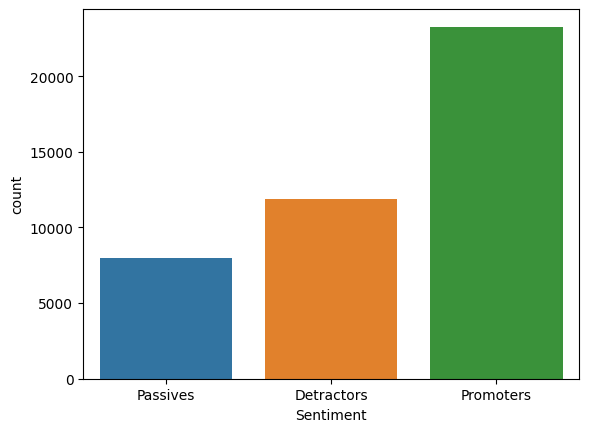

In [ ]:
import seaborn as sns

sns.countplot(x='Sentiment', data=data)

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [ ]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam


In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
from unidecode import unidecode

In [ ]:
#download stopwords, make them uppercase and delete accents

stopwords_list = stopwords.words('spanish')
stopwords_list = [x.upper() for x in stopwords_list]
stopwords_list = [unidecode(x) for x in stopwords_list]
stopwords_list.remove('NO')
stopwords_list.remove('SI')

In [ ]:
 def preprocess_text(sen):
     '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
     in lowercase'''
    
     sentence = sen.upper()

     # Remove punctuations and numbers
     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

     # Single character removal
     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

     # Remove multiple spaces
     sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

     # Remove Stopwords
     pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
     sentence = pattern.sub('', sentence)

      # Remove empty strings
     sentence = re.sub('^\s*$', ' ', sentence)
     sentence = re.sub('^\s*$', '  ', sentence)
     #sentence = re.sub('^\s*$', '   ', sentence)

      # delete sentence with a set of 1 character

     if len(set(sentence)) > 2:
         return sentence



In [ ]:
nps_scores = list(data["NPS"])
X = []
sentences = list(data['Comment'])

for sen in sentences:
    aux = preprocess_text(sen)
    if aux:
        X.append(aux)
    else:
        # save the index of the deleted sentence
        vacios = sentences.index(sen)
        del nps_scores[vacios]
# check for nan values in X

for i in range(len(X)):
  if type(X[i]) != str:
    print(i, X[i])
        
# check for empty strings in X

for i in range(len(X)):
  if X[i] == '  ':
    print(i, X[i])

y = nps_scores

print(len(X))
print(len(y))


y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [ ]:
from sklearn.preprocessing import StandardScaler

# Example: Convert comments to bag-of-words representation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

# Normalize the features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features.toarray())
X_test_features = scaler.transform(X_test_features.toarray())

# Dropout Neural Network

In [ ]:
# Create the neural network model
drop_model = Sequential()
drop_model.add(Dense(128, activation='relu', input_shape=(X_train_features.shape[1],)))
drop_model.add(Dropout(0.2))
drop_model.add(Dense(64, activation='relu'))
drop_model.add(Dropout(0.2))
drop_model.add(Dense(1))  # Output layer with a single neuron for regression

drop_model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=["acc", "categorical_accuracy"])

callbacks = [
    EarlyStopping(
        monitor="loss",
        min_delta=1e-2,
        patience=3,
        verbose=1,
    )
]

# Train the model
history = drop_model.fit(X_train_features, y_train, epochs=100, batch_size=32, verbose=1, callbacks=callbacks)

# Evaluate the model
mse = drop_model.evaluate(X_test_features, y_test)
print("Mean Squared Error (MSE):", mse)

drop_model.save_weights('/content/drive/Shareddrives/datathon/notebooks/weights/' + 'drop.h5', overwrite=True)

Epoch 1/100
1079/1079 [==============================] - 16s 8ms/step - loss: 11.8123 - acc: 0.0173 - categorical_accuracy: 1.0000
Epoch 2/100
1079/1079 [==============================] - 7s 6ms/step - loss: 7.5800 - acc: 0.0168 - categorical_accuracy: 1.0000
Epoch 3/100
1079/1079 [==============================] - 7s 7ms/step - loss: 5.6266 - acc: 0.0169 - categorical_accuracy: 1.0000
Epoch 4/100
1079/1079 [==============================] - 6s 6ms/step - loss: 4.6712 - acc: 0.0169 - categorical_accuracy: 1.0000
Epoch 5/100
1079/1079 [==============================] - 4s 4ms/step - loss: 3.9283 - acc: 0.0171 - categorical_accuracy: 1.0000
Epoch 6/100
1079/1079 [==============================] - 4s 4ms/step - loss: 3.4686 - acc: 0.0180 - categorical_accuracy: 1.0000
Epoch 7/100
1079/1079 [==============================] - 5s 4ms/step - loss: 3.2549 - acc: 0.0196 - categorical_accuracy: 1.0000
Epoch 8/100
1079/1079 [==============================] - 4s 4ms/step - loss: 2.9963 - acc: 0.02

In [ ]:
# Make predictions on new comments
new_comments = ["Odio la aerolinea, me decepcionan", "Me encanta viajar con ustedes", "Ni me gusta ni me desagrada es una experiencia normal", "esta culero", "la tarjeta de credito paso correctamente", "estoy satisfecho con mi viaje", "excelente servicio", "hdp", "chinguen a su madre culeros", "pesimo servicio","para empezar en el mostrador no habia nadie por lo que llegue tarde a mi vuelo despues me cobraron una maleta de mas", "me cancelaron mi vuelo y mi esposa esta enferma en el hospital si se muere y no escucho sus ultimas palabras los voy a hacer pagar"]
new_comments_features = vectorizer.transform(new_comments)
new_comments_features = scaler.transform(new_comments_features.toarray())
predictions = drop_model.predict(new_comments_features)

print("Predictions for Dropout NN:")
for comment, prediction in zip(new_comments, predictions):
    print("Comment:", comment)
    print("Predicted NPS:", prediction[0])
    print('-----------------------')

1/1 [==============================] - 0s 100ms/step
Predictions for Dropout NN:
Comment: Odio la aerolinea, me decepcionan
Predicted NPS: 6.635372
-----------------------
Comment: Me encanta viajar con ustedes
Predicted NPS: 9.666171
-----------------------
Comment: Ni me gusta ni me desagrada es una experiencia normal
Predicted NPS: 8.699904
-----------------------
Comment: esta culero
Predicted NPS: 6.146296
-----------------------
Comment: la tarjeta de credito paso correctamente
Predicted NPS: 9.058466
-----------------------
Comment: estoy satisfecho con mi viaje
Predicted NPS: 9.935371
-----------------------
Comment: excelente servicio
Predicted NPS: 9.6057825
-----------------------
Comment: hdp
Predicted NPS: 2.102059
-----------------------
Comment: chinguen a su madre culeros
Predicted NPS: -1.1103969
-----------------------
Comment: pesimo servicio
Predicted NPS: 1.692965
-----------------------
Comment: para empezar en el mostrador no habia nadie por lo que llegue tarde a